In [1]:
import importlib
import subprocess
import sys
import os

def install_if_missing(package):
    if importlib.util.find_spec(package) is None:
        print(f"Устанавливаю {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    else:
        print(f"{package} уже установлен")

packages = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'phik', 'plotly']
for p in packages:
    install_if_missing(p)

pandas уже установлен
numpy уже установлен
matplotlib уже установлен
seaborn уже установлен
phik уже установлен
plotly уже установлен


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

import warnings
warnings.filterwarnings('ignore')

import plotly
plotly.offline.init_notebook_mode(connected = True)
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from datetime import datetime

from IPython.core.display import display, HTML
display(HTML('<style>.container {width:100% !important; }</style>'))

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Полезные функции

In [3]:
FILE_PATH = r"C:\Users\User\credit-scoring\data\raw"

In [4]:
def load_tables(filepath = FILE_PATH, verbose = True):
    if filepath:
        train = pd.read_csv(os.path.join(filepath, "application_train.csv"))
        test = pd.read_csv(os.path.join(filepath, "application_test.csv"))

    if verbose:
        print("Обучающая выборка загружена", train.shape)
        print("Тестовая выборка загружена", test.shape)

    return train, test   

In [5]:
def nan_df_create(data):
    
    '''
    Function to create a dataframe of percentage of NaN values for each column of the dataframe
    
    Inputs:
        data: 
            DataFrame
    
    Returns:
        DataFrame of NaN percentages
    '''
    
    nan_percentages = data.isna().sum() * 100 / len(data)
    df = pd.DataFrame({'column' : nan_percentages.index, 'percent' : nan_percentages.values})
    
  
    df.sort_values(by = 'percent', ascending = False, inplace = True)
    
    return df

In [6]:
def plot_nan_percent(df_nan, title_name, tight_layout = True, figsize = (20,8), grid = False, rotation = 90):
    
    '''
    Function to plot Bar Plots of NaN percentages for each Column with missing values
    
    Inputs:
        df_nan: 
            DataFrame of NaN percentages
        title_name: 
            Name of table to be displayed in title of plot
        tight_layout: bool, default = True
            Whether to keep tight layout or not
        figsize: tuple, default = (20,8)
            Figure size of plot    
        grid: bool, default = False
            Whether to draw gridlines to plot or not
        rotation: int, default = 0
            Degree of rotation for x-tick labels

    '''
    
  
    if df_nan.percent.sum() != 0:
        print(f"Number of columns having NaN values: {df_nan[df_nan['percent'] != 0].shape[0]} columns")
        
        nan_data = df_nan[df_nan['percent'] > 0]
        
        fig, ax = plt.subplots(figsize=figsize, tight_layout=tight_layout)
        
     
        for i, (col, percent) in enumerate(zip(nan_data['column'], nan_data['percent'])):
     
            norm_percent = percent / 100
            color = plt.cm.RdYlBu_r(norm_percent)  
            
            bar = ax.bar(i, percent, color=color, alpha=0.8, edgecolor='black', linewidth=0.5)
        
        ax.set_xticks(range(len(nan_data)))
        ax.set_xticklabels(nan_data['column'], rotation=rotation)
        ax.set_xlabel('Column Name')
        ax.set_ylabel('Percentage of NaN values')
        ax.set_title(f'Percentage of NaN values in {title_name}')
        
        
        sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlBu_r, norm=plt.Normalize(0, 100))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label('NaN Percentage')
        
        if grid:
            ax.grid(alpha=0.3)
        
        plt.show()
        
    else:
        print(f"The dataframe {title_name} does not contain any NaN values.")

In [7]:
class CorrelationMatrix:

    def __init__(self, data, columns_to_drop, figsize = (25, 23), mask_upper = True, tight_layout = True, linewidth = 0.1, 
                 fontsize = 10, cmap = 'Blues'):
        self.data = data
        self.columns_to_drop = columns_to_drop
        self.figsize = figsize
        self.mask_upper = mask_upper
        self.tight_layout = tight_layout
        self.linewidth = linewidth
        self.fontsize = fontsize
        self.cmap = cmap


    def plot_correlation_matrix(self):

        self.corr_data = self.data.drop(self.columns_to_drop + ['TARGET'], axis = 1).corr()

        if self.mask_upper:
            mask_array = np.ones(self.corr_data.shape)
            mask_array = np.triu(mask_array)
        else:
            mask_array = np.zeros(self.corr_data.shape)

        plt.figure(figsize = self.figsize, tight_layout = self.tight_layout)
        sns.heatmap(self.corr_data, annot = False, mask = mask_array, linewidth = self.linewidth, cmap = self.cmap)
        plt.xticks(rotation = 90, fontsize = self.fontsize)
        plt.yticks(fontsize = self.fontsize)
        plt.title("Корреляционная матрица для числовых признаков")
        plt.show()


    def target_top_corr(self, target_top_columns =10):
        
        
        phik_target_arr = np.zeros(self.corr_data.shape[1])
        for index, column in enumerate(self.corr_data.columns):
            phik_target_arr[index] = self.data[['TARGET', column]].phik_matrix().iloc[0,1]
        top_corr_target_df = pd.DataFrame({'Column Name': self.corr_data.columns, 'Phik-Correlation' : phik_target_arr})
        top_corr_target_df = top_corr_target_df.sort_values(by = 'Phik-Correlation', ascending = False)
        
        return top_corr_target_df.iloc[:target_top_columns]
        
            
        

In [8]:
def plot_phik_matrix(data, categorical_columns, figsize = (20, 20), mask_upper = True, tight_layout = True, linewidth = 0.1, 
                fontsize = 10, cmap = 'Blues', show_target_top_corr = True, 
                target_top_columns = 10):
    data_for_phik = data[categorical_columns].astype("object")
    phik_matrix = data_for_phik.phik_matrix()
    if mask_upper:
        mask_array = np.ones(phik_matrix.shape)
        mask_array = np.triu(mask_array)
    else:
        mask_array = np.zeros(phik_matrix.shape)
        
    plt.figure(figsize = figsize, tight_layout = tight_layout)
    sns.heatmap(phik_matrix, annot = False, mask = mask_array, linewidth = linewidth, cmap = cmap)
    plt.xticks(rotation = 90, fontsize = fontsize)
    plt.yticks(rotation = 0, fontsize = fontsize)
    plt.title("Phi-K Correlation Heatmap for Categorical Features")
    plt.show()
    print("-"*100)

    if show_target_top_corr:
        #Seeing the top columns with highest correlation with the target variable in application_train
        print("Categories with highest values of Phi-K Correlation value with Target Variable are:")
        phik_df = pd.DataFrame({'Column Name' : phik_matrix.TARGET.index[1:], 'Phik-Correlation' : phik_matrix.TARGET.values[1:]})
        phik_df = phik_df.sort_values(by = 'Phik-Correlation', ascending = False)
        display(phik_df.head(target_top_columns))
        print("-"*100) 

In [9]:
def plot_categorical_variables_bar(data, column_name, figsize = (18,6), percentage_display = True, plot_defaulter = True, rotation = 0, horizontal_adjust = 0, fontsize_percent = 'xx-small'):
    print(f"Total Number of unique categories of {column_name} = {len(data[column_name].unique())}")
    
    plt.figure(figsize = figsize, tight_layout = False)
    sns.set(style = 'whitegrid', font_scale = 1.2)
    
    #plotting overall distribution of category
    plt.subplot(1,2,1)
    data_to_plot = data[column_name].value_counts().sort_values(ascending = False)
    ax = sns.barplot(x = data_to_plot.index, y = data_to_plot, palette = 'Set1')
    
    if percentage_display:
        total_datapoints = len(data[column_name].dropna())
        for p in ax.patches:
            ax.text(p.get_x() + horizontal_adjust, p.get_height() + 0.005 * total_datapoints, '{:1.02f}%'.format(p.get_height() * 100 / total_datapoints), fontsize = fontsize_percent)
        
    plt.xlabel(column_name, labelpad = 10)
    plt.title(f'Distribution of {column_name}', pad = 20)
    plt.xticks(rotation = rotation)
    plt.ylabel('Counts')
    
    #plotting distribution of category for Defaulters
    if plot_defaulter:
        percentage_defaulter_per_category = (data[column_name][data.TARGET == 1].value_counts() * 100 / data[column_name].value_counts()).dropna().sort_values(ascending = False)

        plt.subplot(1,2,2)
        sns.barplot(x = percentage_defaulter_per_category.index, y = percentage_defaulter_per_category, palette = 'Set2')
        plt.ylabel('Percentage of Defaulter per category')
        plt.xlabel(column_name, labelpad = 10)
        plt.xticks(rotation = rotation)
        plt.title(f'Percentage of Defaulters for each category of {column_name}', pad = 20)
    plt.show()

In [10]:
def plot_categorical_variables_pie(data, column_name, plot_defaulter = True, hole = 0):
    
    if plot_defaulter:
        cols = 2
        specs = [[{'type' : 'domain'}, {'type' : 'domain'}]]
        titles = [f'Distribution of {column_name} for all Targets', f'Percentage of Defaulters for each category of {column_name}']
    else:
        cols = 1
        specs = [[{'type': 'domain'}]]
        titles = [f'Distribution of {column_name} for all Targets']
        
    values_categorical = data[column_name].value_counts()
    labels_categorical = values_categorical.index
    
    fig = make_subplots(rows = 1, cols = cols, 
                       specs = specs, 
                       subplot_titles = titles)
    
    fig.add_trace(go.Pie(values = values_categorical, labels = labels_categorical, hole = hole, 
                         textinfo = 'label+percent', textposition = 'inside'), row = 1, col = 1)
    
    if plot_defaulter:
        percentage_defaulter_per_category = data[column_name][data.TARGET == 1].value_counts() * 100 / data[column_name].value_counts()
        percentage_defaulter_per_category.dropna(inplace = True)
        percentage_defaulter_per_category = percentage_defaulter_per_category.round(2)
        
        fig.add_trace(go.Pie(values = percentage_defaulter_per_category, labels = percentage_defaulter_per_category.index, 
                             hole = hole, textinfo = 'label+value', hoverinfo = 'label+value'), row = 1, col = 2)
        
    fig.update_layout(title = f'Distribution of {column_name}')
    fig.show()
def print_unique_categories(data, column_name, show_counts = False):


    print(f"The unique categories of '{column_name}' are:\n{data[column_name].unique()}")

    
    if show_counts:
        print(f"Counts of each category are:\n{data[column_name].value_counts()}")
 

In [11]:

def plot_cdf(data, column_name, log_scale = False, figsize = (12,8)):

        
    percentile_values = data[[column_name]].dropna().sort_values(by = column_name)
    percentile_values['Percentile'] = [ele / (len(percentile_values) - 1) for ele in range(len(percentile_values))]

    plt.figure(figsize = figsize)
    if log_scale:
        plt.xscale('log')
        plt.xlabel(column_name + ' - (log-scale)')
    else:
        plt.xlabel(column_name)
    plt.plot(percentile_values[column_name], percentile_values['Percentile'], color = 'red')
    plt.ylabel('Probability')
    plt.title('CDF of {}'.format(column_name))
    plt.show()

In [12]:
def print_percentiles(data, column_name, percentiles = None):
    
    print('-'*100)
    if not percentiles:
        percentiles = list(range(0,80,25)) + list(range(90,101,2))
    for i in percentiles:
        print(f'The {i}th percentile value of {column_name} is {np.percentile(data[column_name].dropna(), i)}')
    print("-"*100)

In [13]:
def plot_continuous_variables(data, column_name, plots = ['distplot', 'CDF', 'box', 'violin'], scale_limits = None, figsize = (20,8), histogram = True, log_scale = False):
    

    data_to_plot = data.copy()
    if scale_limits:
        #taking only the data within the specified limits
        data_to_plot[column_name] = data[column_name][(data[column_name] > scale_limits[0]) & (data[column_name] < scale_limits[1])]

    number_of_subplots = len(plots)
    plt.figure(figsize = figsize)
    sns.set_style('whitegrid')
    
    for i, ele in enumerate(plots):
        plt.subplot(1, number_of_subplots, i + 1)
        plt.subplots_adjust(wspace=0.25)
        
        if ele == 'CDF':
            #making the percentile DataFrame for both positive and negative Class Labels
            percentile_values_0 = data_to_plot[data_to_plot.TARGET == 0][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_0['Percentile'] = [ele / (len(percentile_values_0)-1) for ele in range(len(percentile_values_0))]
            
            percentile_values_1 = data_to_plot[data_to_plot.TARGET == 1][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_1['Percentile'] = [ele / (len(percentile_values_1)-1) for ele in range(len(percentile_values_1))]
            
            plt.plot(percentile_values_0[column_name], percentile_values_0['Percentile'], color = 'red', label = 'Non-Defaulters')
            plt.plot(percentile_values_1[column_name], percentile_values_1['Percentile'], color = 'black', label = 'Defaulters')
            plt.xlabel(column_name)
            plt.ylabel('Probability')
            plt.title('CDF of {}'.format(column_name))
            plt.legend(fontsize = 'medium')
            if log_scale:
                plt.xscale('log')
                plt.xlabel(column_name + ' - (log-scale)')
            
        if ele == 'distplot':  
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 0].dropna(),
                         label='Non-Defaulters', hist = False, color='red')
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 1].dropna(),
                         label='Defaulters', hist = False, color='black')
            plt.xlabel(column_name)
            plt.ylabel('Probability Density')
            plt.legend(fontsize='medium')
            plt.title("Dist-Plot of {}".format(column_name))
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)')

        if ele == 'violin':  
            sns.violinplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Violin-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

        if ele == 'box':  
            sns.boxplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Box-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

    plt.show()

## EDA

### Шаги:

1. Для каждой таблицы необходимо проверить количество записей в ней, количество пропусков, признаков и тд.<br>
2. Далее, будут изучены некоторые признаки относительно целевой переменной:
   - для категориальных будут использованы в основном столбчатые диаграммы (Bar Plots), круговые диаграммы (Pie Charts)
   - Для числовых/непрерывных признаков будут использованы PDFs, CDFs, Box-plot, Violin-plots.

Для категориальных признаков обычно используются Bar Plots, Pie Charts. Использование одного из них будет зависеть от количества уникальных категорий в категориальном признаке: если категорий слишком много, то отображение на круговой диаграмме данных будет слишком громоздким, поэтому столбчатые диаграммы предпочтительнее. <br>
1. Сначала будет отрисовываться распределение каждого категориального признака по всем данным, которые есть
2. затем процент дефолтов по каждой категории

Для числовых/непрерывных признаков будут использованы 4 вида графиков:
1. DistPlots - используется для получения PDF (Probability Distribution Function), чтобы посмотреть, где лежит большинство данных
2. CDF(Cumulative Distribution Function) - покажет, какой процент данных лежит ниже определенного порога.
3. Box Plots - для того, чтобы посмотреть диапазон значений выбранной переменной (показывает 25ый, 50ый, 75ый квантили) +  получить представление о выбросах
4. Violin-Plots - сочетает в себе черты 1 и 3 вида графиков. По вертикали работает по схожему с Box Plots (показывает квантили), по горизонтали - функция плотности вероятности (PDF) непрерывной переменной.

# Задача: по набору признаков (данные из анкет) предсказать, случится ли у клиента дефолт

In [14]:
train, test = load_tables(FILE_PATH)

Обучающая выборка загружена (307511, 122)
Тестовая выборка загружена (48744, 121)


### application_train.csv и application_test.csv

### Описание признаков

В этом датасете каждая строчка - заявка на кредит

In [15]:
print(f"Количество повторяющих значений в обучающей выборке {train.shape[0] - train.duplicated().shape[0]}")

Количество повторяющих значений в обучающей выборке 0


In [16]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [17]:
print(f"Количество повторяющихся значений в тестовой выборке {test.shape[0] - test.duplicated().shape[0]}")

Количество повторяющихся значений в тестовой выборке 0


In [18]:
test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

In [19]:
train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.97

In [20]:
test.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,48744.000000,48744.000000,4.874400e+04,4.874400e+04,48720.000000,4.874400e+04,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,16432.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,28212.000000,48736.000000,40076.000000,24857.000000,21103.000000,25888.000000,16926.000000,15249.000000,23555.000000,25165.000000,25423.000000,16278.000000,20490.000000,15964.000000,25192.000000,15397.000000,22660.000000,24857.000000,21103.000000,25888.000000,16926.000000,15249.000000,23555.000000,25165.000000,25423.000000,16278.000000,20490.000000,15964.000000,25192.000000,15397.000000,22660.000000,24857.000000,21103.000000,25888.000000,16926.000000,15249.000000,23555.000000,25165.000000,25423.000000,16278.000000,20490.000000,15964.000000,25192.000000,15397.000000,22660.000000,26120.000000,48715.000000,48715.000000,48715.000000,48715.000000,48744.000000,48744.0,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.0,48744.000000,48744.0,48744.0,48744.0,48744.0,48744.0,48744.0,48744.000000,48744.0,48744.0,48744.0,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000
mean,277796.676350,0.397054,1.784318e+05,5.167404e+05,29426.240209,4.626188e+05,0.021226,-16068.084605,67485.366322,-4967.652716,-3051.712949,11.786027,0.999979,0.809720,0.204702,0.998400,0.263130,0.162646,2.146767,2.038159,2.012596,12.007365,0.018833,0.055166,0.042036,0.077466,0.224664,0.174216,0.501180,0.518021,0.500106,0.122388,0.090065,0.978828,0.751137,0.047624,0.085168,0.151777,0.233706,0.238423,0.067192,0.105885,0.112286,0.009231,0.029387,0.119078,0.088998,0.978292,0.758327,0.045223,0.080570,0.147161,0.229390,0.233854,0.065914,0.110874,0.110687,0.008358,0.028161,0.122809,0.089529,0.978822,0.754344,0.047420,0.084128,0.151200,0.233154,0.237846,0.068069,0.107063,0.113368,0.008979,0.029296,0.107129,1.447644,0.143652,1.435738,0.101139,-1077.766228,0.0,0.786620,

#### Выводы

1. Обучающая выборка имеет 307k строк, 122 признака
2. TARGET либо 0, либо 1, где  0 - кредит погашен, 1 - дефолт.
3. SK_ID_CURR - колонка с ID, никакой информации для модели
4. Тестовая выборка содержит 48k строк, 121 признак
5. не содержит целевой переменной

Number of columns having NaN values: 67 columns


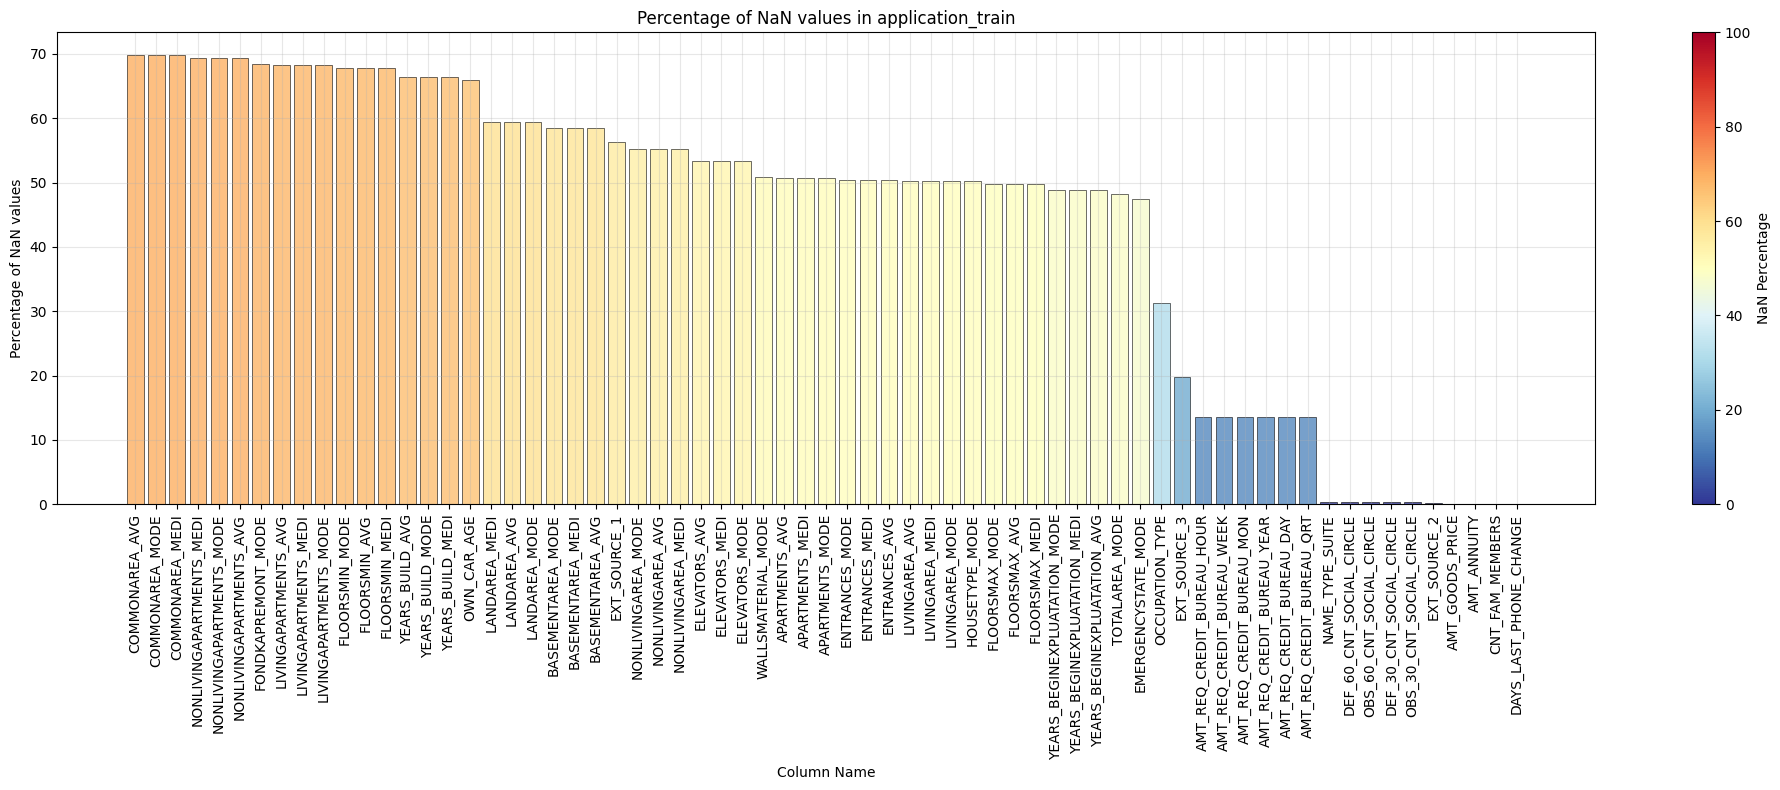

In [21]:
plot_nan_percent(nan_df_create(train), 'application_train', grid = True)

Number of columns having NaN values: 64 columns


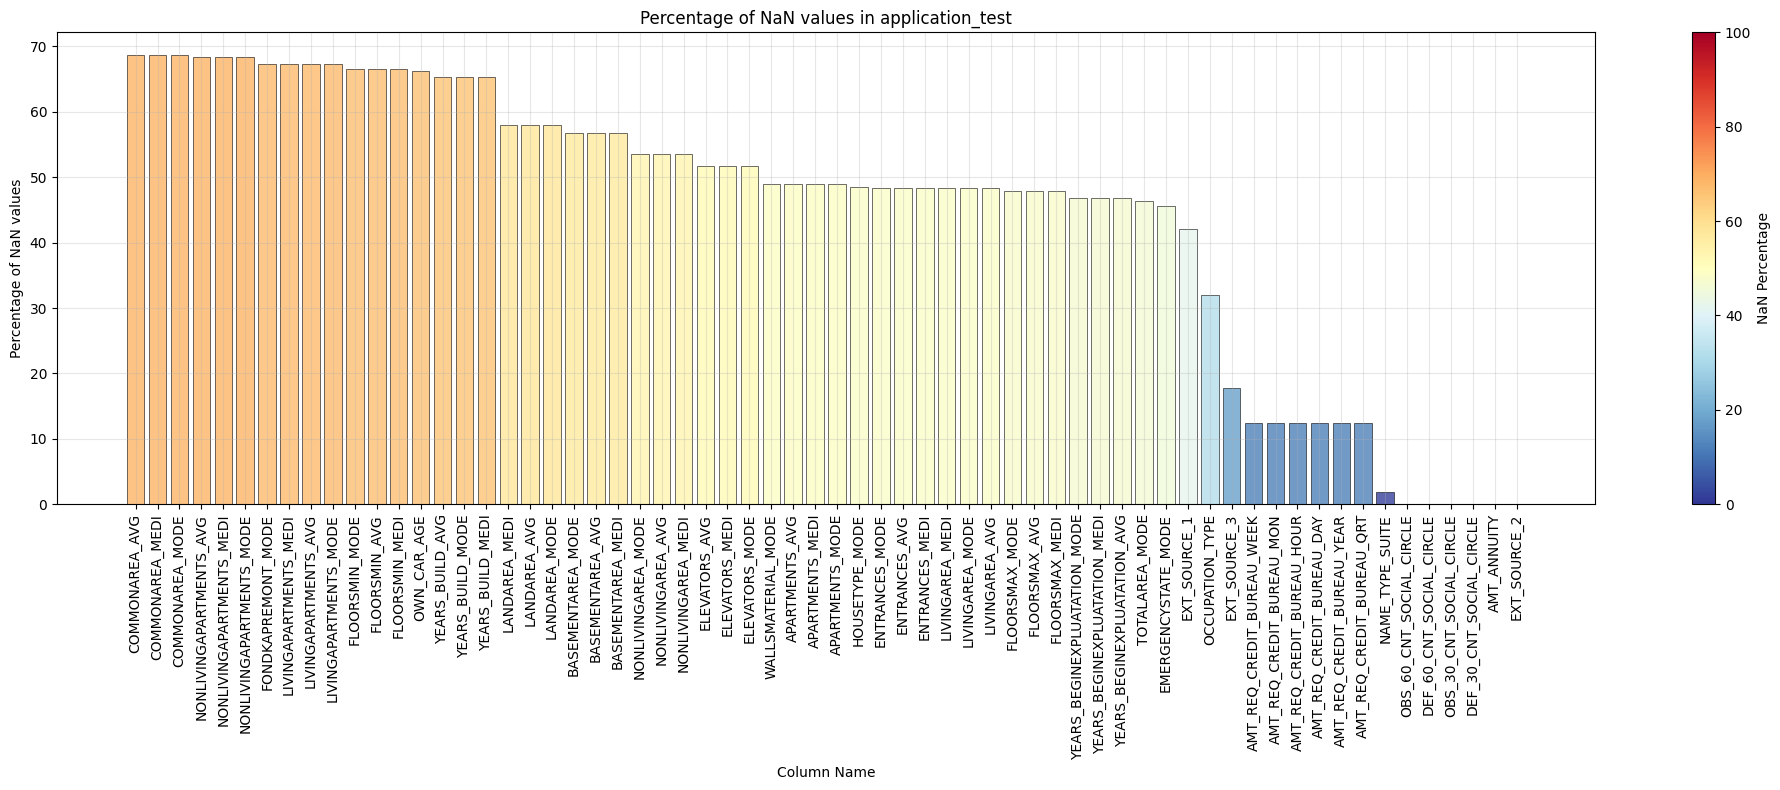

In [22]:
plot_nan_percent(nan_df_create(test), 'application_test', grid = True)

### Выводы

train
1. 67 колонок из 122 содержат пропущенные значения, слишком много, поэтому нельзя удалять, так как это будет потеря огромного пласта информации
2. Самые большой процент пропусков - примерно 70% (COMMONAREA_AVG, COMMONAREA_MEDI и др)
3. Большая часть пропусков относится к данным об апартаментах заемщика. Мб эти данные были опциональны при заполнении анкеты.

test
1. Все плюс минус похоже на обучающую выборку

### Распределение целевой переменной

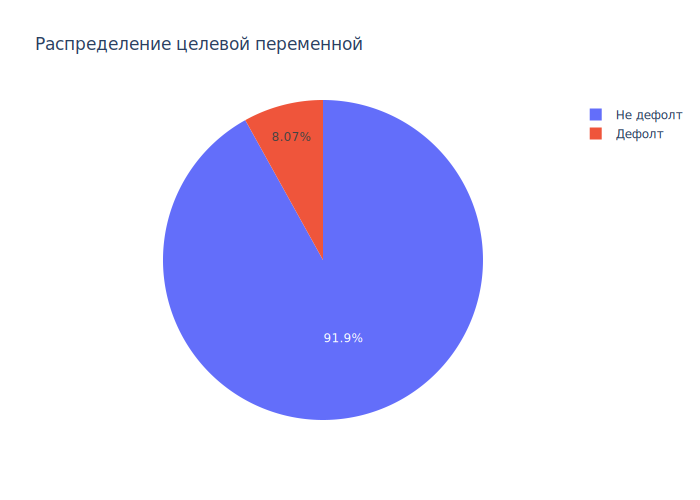

In [23]:
target_distribution = train.TARGET.value_counts()
labels = ['Не дефолт', 'Дефолт']

fig = go.Figure(data = [
                go.Pie(values = target_distribution, labels = labels)], 
                layout = go.Layout(title = 'Распределение целевой переменной'))

fig.show(renderer = 'svg')

### Выводы

1. Классы явно несбалансированные, 8% - дефолт, 92% - кредит погашен.
2. Значит, нельзя подавать данные в том виде, в котором они есть, в модели чувствительные к дисбалансу классов
3. Accuracy не подойдет в качестве метрики, подойдут ROC-AUC Score, Log-Loss, F1-Score, Confusion Matrix.
4. В этом датасете есть только несколько ситуаций, в которых люди, получившие дефолт, демонстрируют различное поведение. Следовательно, нужно проанализировать и выбросы

### Phi-K матрица (φ-K, Phi-Korrelation)

Отличается от обычной корреляции тем, что можно использовать для категориальных признаков.

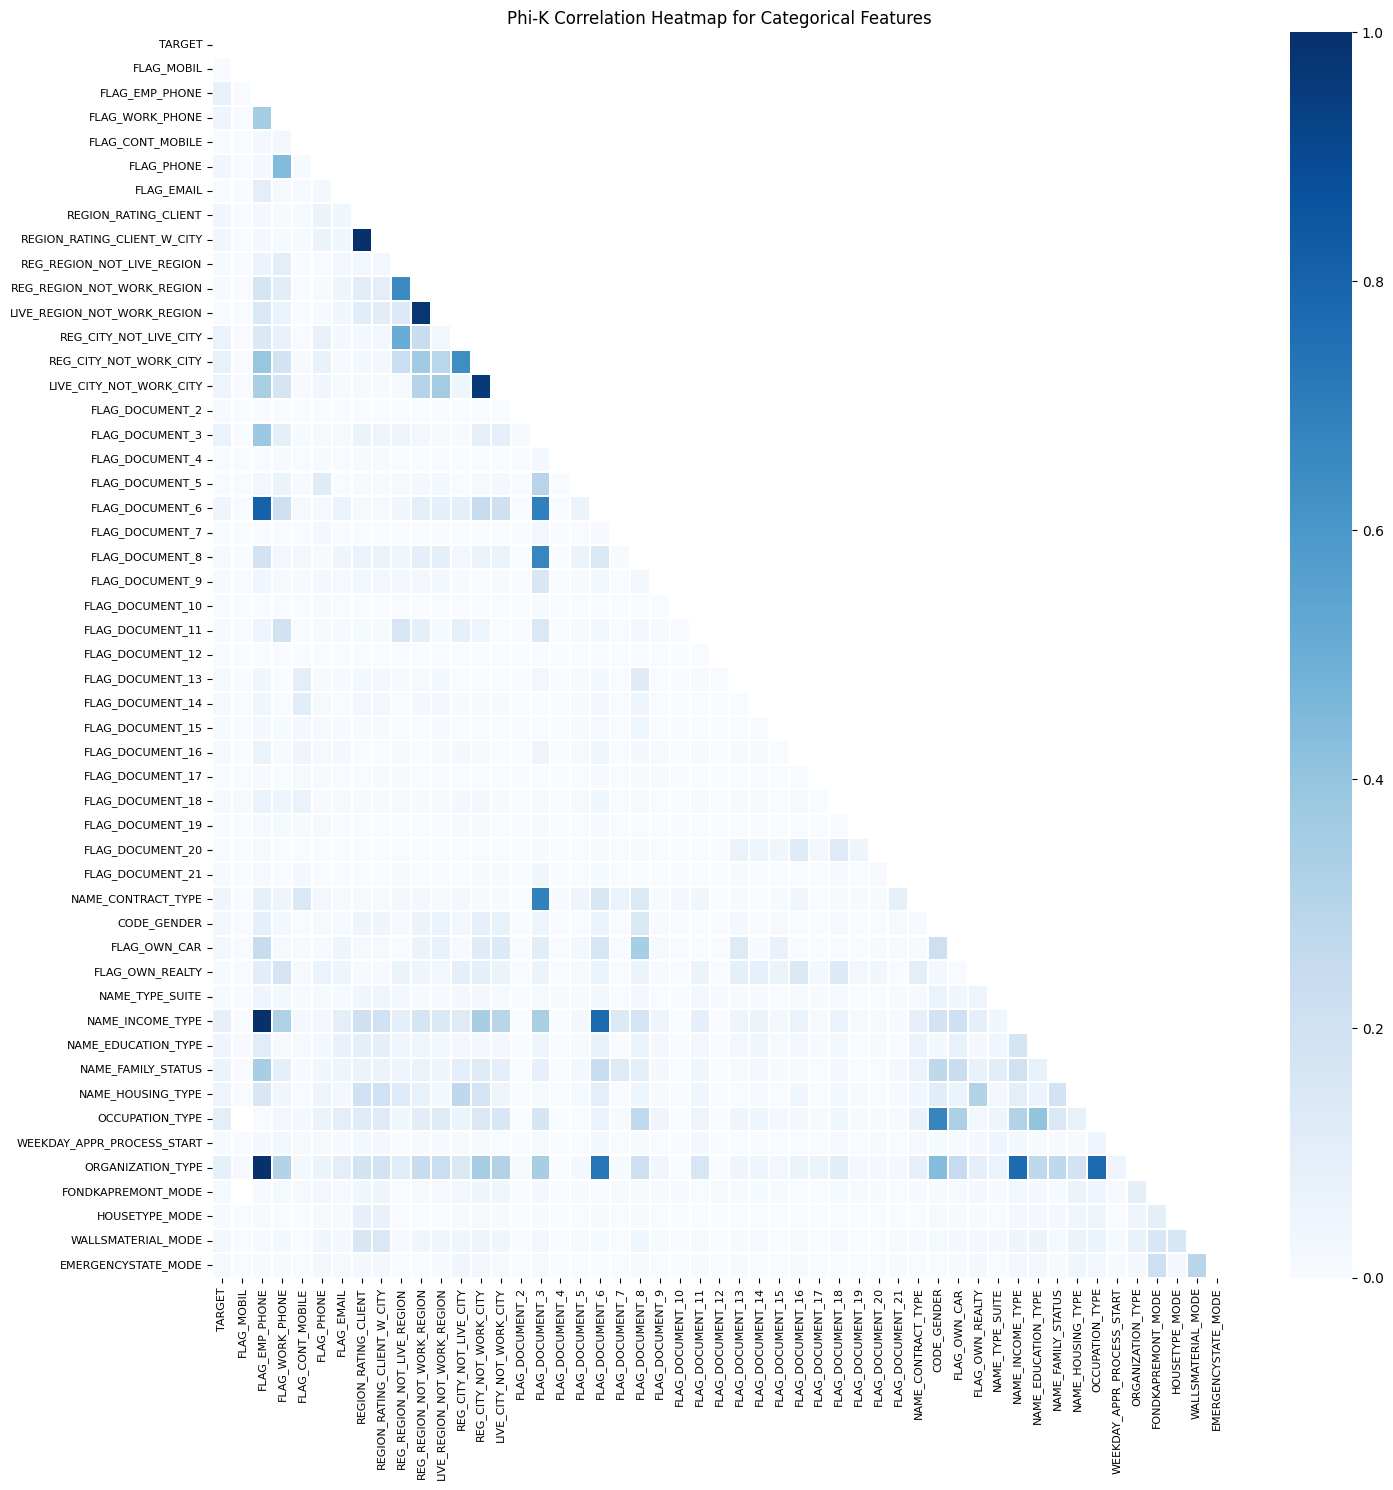

----------------------------------------------------------------------------------------------------
Categories with highest values of Phi-K Correlation value with Target Variable are:


,Column Name,Phik-Correlation
43,OCCUPATION_TYPE,0.102846
45,ORGANIZATION_TYPE,0.089164
39,NAME_INCOME_TYPE,0.084831
12,REG_CITY_NOT_WORK_CITY,0.079946
1,FLAG_EMP_PHONE,0.072087
11,REG_CITY_NOT_LIVE_CITY,0.069588
15,FLAG_DOCUMENT_3,0.069525
41,NAME_FAMILY_STATUS,0.056043
42,NAME_HOUSING_TYPE,0.051107
13,LIVE_CITY_NOT_WORK_CITY,0.050956


----------------------------------------------------------------------------------------------------


In [24]:
categorical_columns = ['TARGET','FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
                                   'FLAG_PHONE', 'FLAG_EMAIL','REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY',
                                  'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
                                   'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 
                                'LIVE_CITY_NOT_WORK_CITY'] + ['FLAG_DOCUMENT_' + str(i) for i in range(2,22)] + train.dtypes[
                                    train.dtypes == 'object'].index.tolist()
plot_phik_matrix(train, categorical_columns, figsize = (15,15), fontsize = 8)

### Выводы

1. большинство категориальных признаков нескоррелированы
2. несколько признаков имеют чуть более высокую корреляцию:
   - REGION_RATING_CLIENT_W_CITY и REGION_RATING_CLIENT -потому что у них плюс минус одинаковая суть
   - LIVE_REGION_NOT_WORK_REGION  и REG_REGION_NOT_WORK_REGION
   - NAME_INCOME_TYPE, ORGANIZATION_TYPE и FLAG_EMP_PHONE
3. некоторые признаки (OCCUPATION_TYPE, ORGANIZATION_TYPE, NAME_INCOME_TYPE, REG_CITY_NOT_WORK_CITY ) имеют высокую корреляцию с целевой переменной

### Корреляция числовых признаков

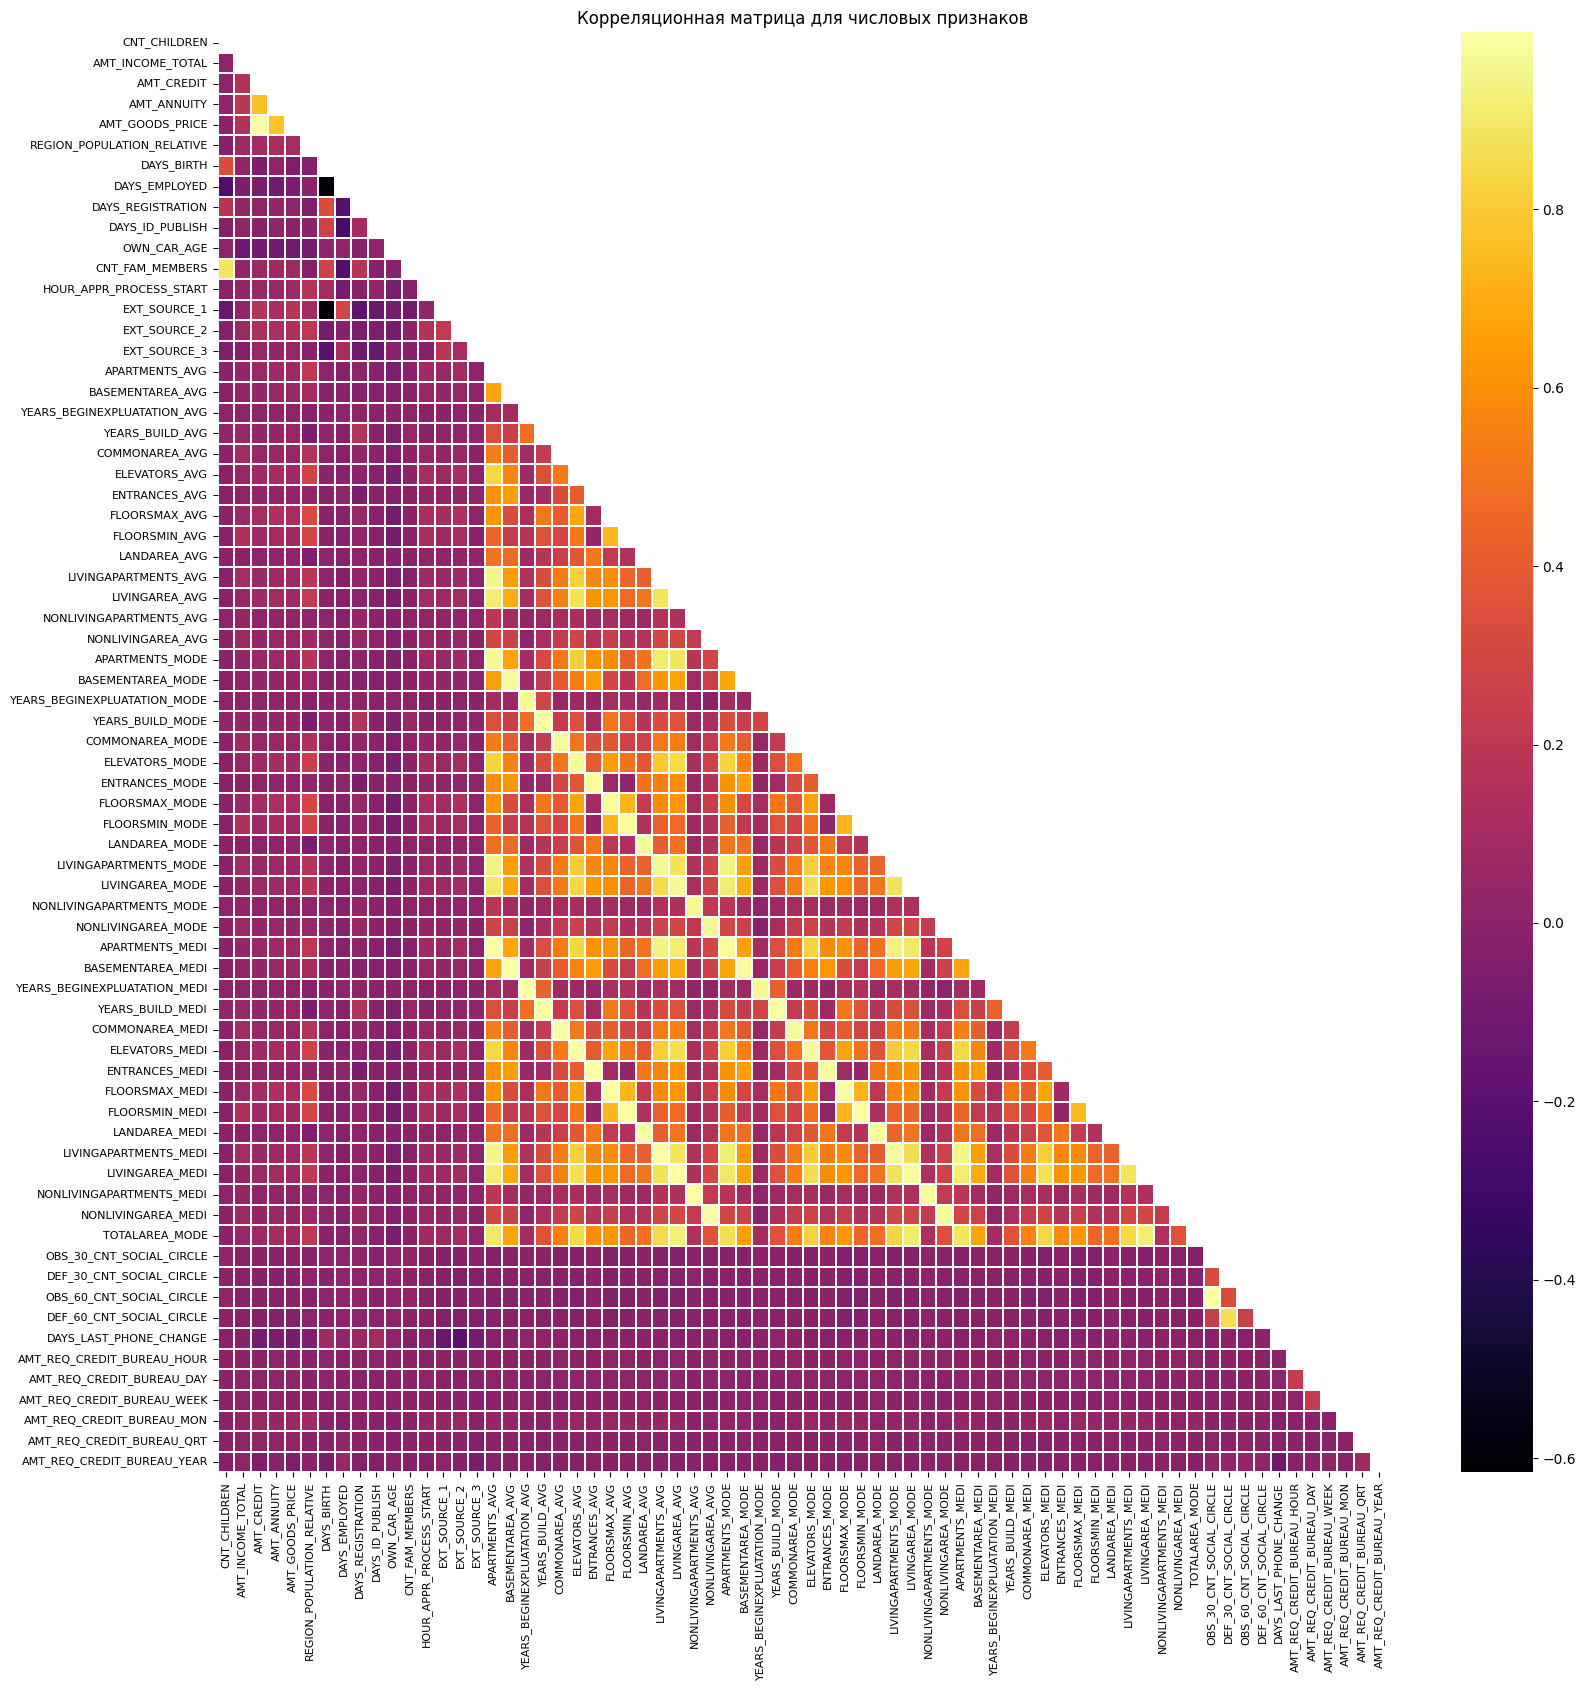

In [25]:
columns_to_drop = ['SK_ID_CURR'] + list(set(categorical_columns) - set(['TARGET']))
corr_mat = CorrelationMatrix(train, columns_to_drop, figsize = (17, 17), fontsize = 8, cmap = 'inferno')
corr_mat.plot_correlation_matrix()

In [26]:
top_corr_target_df = corr_mat.target_top_corr()
display(top_corr_target_df)

interval columns not set, guessing: ['TARGET', 'CNT_CHILDREN']
interval columns not set, guessing: ['TARGET', 'AMT_INCOME_TOTAL']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT']
interval columns not set, guessing: ['TARGET', 'AMT_ANNUITY']
interval columns not set, guessing: ['TARGET', 'AMT_GOODS_PRICE']
interval columns not set, guessing: ['TARGET', 'REGION_POPULATION_RELATIVE']
interval columns not set, guessing: ['TARGET', 'DAYS_BIRTH']
interval columns not set, guessing: ['TARGET', 'DAYS_EMPLOYED']
interval columns not set, guessing: ['TARGET', 'DAYS_REGISTRATION']
interval columns not set, guessing: ['TARGET', 'DAYS_ID_PUBLISH']
interval columns not set, guessing: ['TARGET', 'OWN_CAR_AGE']
interval columns not set, guessing: ['TARGET', 'CNT_FAM_MEMBERS']
interval columns not set, guessing: ['TARGET', 'HOUR_APPR_PROCESS_START']
interval columns not set, guessing: ['TARGET', 'EXT_SOURCE_1']
interval columns not set, guessing: ['TARGET', 'EXT_SOURCE_2']
interval columns 

,Column Name,Phik-Correlation
15,EXT_SOURCE_3,0.247680
13,EXT_SOURCE_1,0.217846
14,EXT_SOURCE_2,0.213965
6,DAYS_BIRTH,0.102395
63,DAYS_LAST_PHONE_CHANGE,0.073215
7,DAYS_EMPLOYED,0.072094
9,DAYS_ID_PUBLISH,0.067769
4,AMT_GOODS_PRICE,0.059093
23,FLOORSMAX_AVG,0.058673
51,FLOORSMAX_MEDI,0.058445


### Выводы


1. Тепловая карта показывает корреляция признаков друг с другом
2. Большинство признаков нескоррелированы
3. Часть из скоррелированных признаков несет информацию о какой-то характеристике апартаментов
4. Скоррелированные признаки будут удалены, так как содержат похожую информацию
5. EXT_SOURCE  сильно скоррелирован с целевой перменной

## Категориальные переменные

### Распределение категориальной переменной NAME_CONTACT_TYPE

In [27]:
print_unique_categories(train, 'NAME_CONTRACT_TYPE')
plot_categorical_variables_pie(train, 'NAME_CONTRACT_TYPE', hole = 0.5)
plt.tight_layout()

The unique categories of 'NAME_CONTRACT_TYPE' are:
['Cash loans' 'Revolving loans']


<Figure size 640x480 with 0 Axes>

### Выводы

1. Доля тех, кто взял возобновлемые кредиты - 9.52 % , обычные - 90.5 %.
2. Доля дефолтов среди тех, кто взял возобновляемые - 5.48 %, обычные - 8.35 %

### CODE GENDER


In [28]:
print_unique_categories(train, 'CODE_GENDER', show_counts = True)
plot_categorical_variables_pie(train, "CODE_GENDER")
plt.tight_layout()

The unique categories of 'CODE_GENDER' are:
['M' 'F' 'XNA']
Counts of each category are:
CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

### Выводы


1. Есть строки с XNA, их можно удалить
2. Мужчин - 34.2  %, женщин - 65.8%
3. Тем не менее, дефолтов среди мужчин на 3 % больше.

### FLAG_EMP_PHONE
оставил или нет рабочий номер (0 -  не оставил, 1 - оставил)

In [29]:
print_unique_categories(train, 'FLAG_EMP_PHONE')
plot_categorical_variables_pie(train, column_name = 'FLAG_EMP_PHONE', hole = 0.5)
plt.tight_layout()

The unique categories of 'FLAG_EMP_PHONE' are:
[1 0]


<Figure size 640x480 with 0 Axes>

### Выводы
1. Большинство оставляют рабочий номер телефона
2. При этом число дефолтов среди тех, кто оставил - выше
3. Мб они предоставляют рабочий номер, чтобы их не беспокоили по личному

### REGION_RATING_CLIENT_W_CITY
Это своего рода рейтинг региона, составленный Home Credit на основе исследований. Берет в учет город проживания клиента
Содержит значения от 1 до 3. (чем ниже, тем лучше)

In [30]:
print_unique_categories(train, 'REGION_RATING_CLIENT_W_CITY')
plot_categorical_variables_pie(train, column_name = 'REGION_RATING_CLIENT_W_CITY', hole = 0.5)
plt.tight_layout()

The unique categories of 'REGION_RATING_CLIENT_W_CITY' are:
[2 1 3]


<Figure size 640x480 with 0 Axes>

### Выводы
1. Большинство клиентов живут в городах с рейтингом 2.(74.6%)
2. Меньше всего дефолтов в городах 1, больше всего в городах с 3 (4.84% vs 11.4%)

### NAME_EDUCATION_TYPE
Образование, которое закончил клиент
1. Lower-secondary - неполное среднее
2. Secondary/secondary special - среднее общее/среднее профессиональное
3. Incomplete higher - незаконченное высшее
4. Higher Education - высшее образование
5. Academic degree - ученая степень

The unique categories of 'NAME_EDUCATION_TYPE' are:
['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
Counts of each category are:
NAME_EDUCATION_TYPE
Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: count, dtype: int64
Total Number of unique categories of NAME_EDUCATION_TYPE = 5


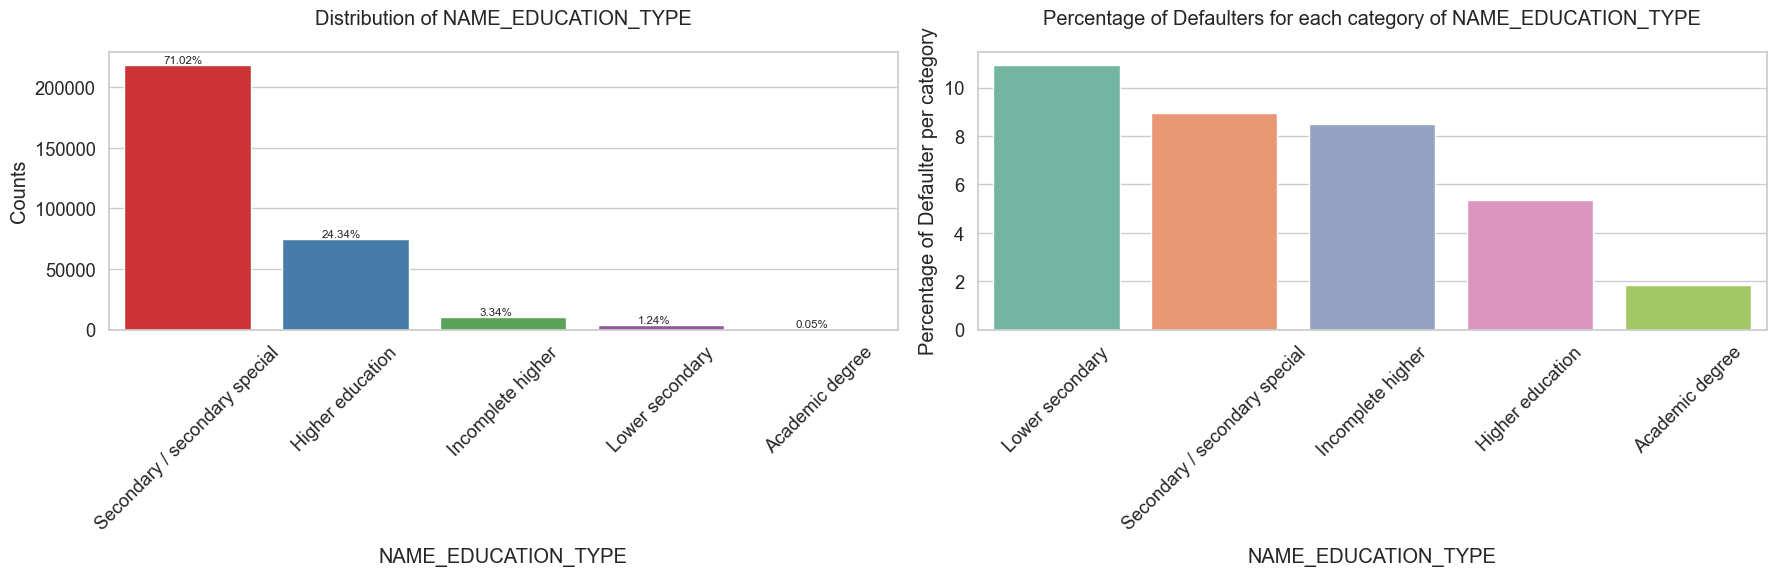

In [31]:

print_unique_categories(train, 'NAME_EDUCATION_TYPE', show_counts = True)
plot_categorical_variables_bar(train, column_name = 'NAME_EDUCATION_TYPE', rotation = 45, horizontal_adjust = 0.25)

### Выводы
1. Большинство (71.02%) закончили среднее общее/среднее профессиональное
2. Большая часть не вернувших долг не закончила и среднее общее
3. Меньше всего заемщиков среди людей с ученой степенью и, соответственно, меньше всего дефолтов

### OCCUPATION_TYPE
Профессия клиента. Больше всего коррелирует с целевой переменной

The unique categories of 'OCCUPATION_TYPE' are:
['Laborers' 'Core staff' 'Accountants' 'Managers' nan 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff' 'Low-skill Laborers' 'Realty agents' 'Secretaries'
 'IT staff' 'HR staff']
Total Number of unique categories of OCCUPATION_TYPE = 19


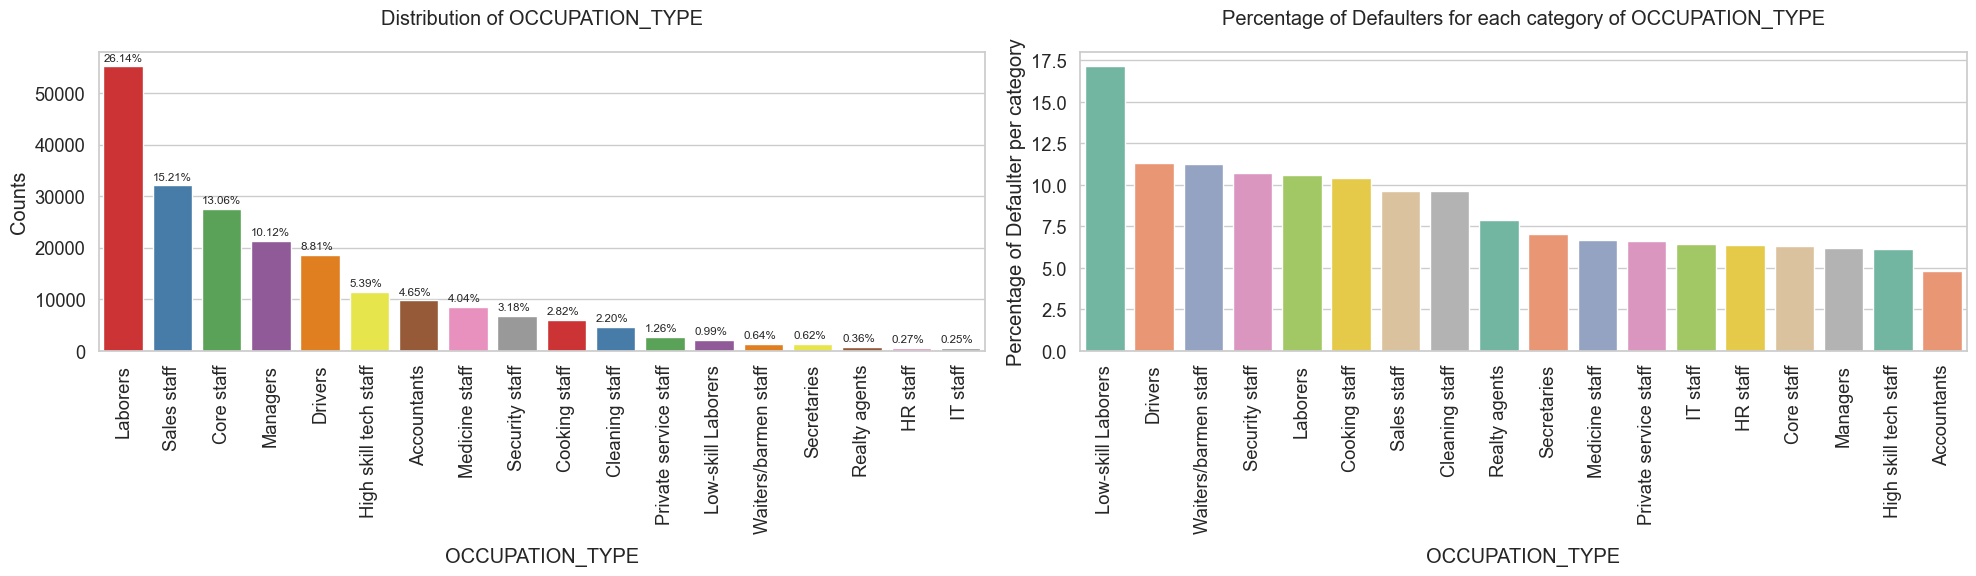

In [32]:
print_unique_categories(train, 'OCCUPATION_TYPE')

plot_categorical_variables_bar(train, column_name = 'OCCUPATION_TYPE', figsize = (20,6), rotation = 90)

### Выводы
1. Низкоквалифициронные рабоычие имеют самый высокий процент дефолтов.
2. Все работы, требующие высшего образования, имеют низкий процент дефолтов

### ORGANIZATION_TYPE
По смыслу похожа на OCCUPATION_TYPE, тоже важна для предсказания дефолта

Total Number of categories of ORGANIZATION_TYPE = 58


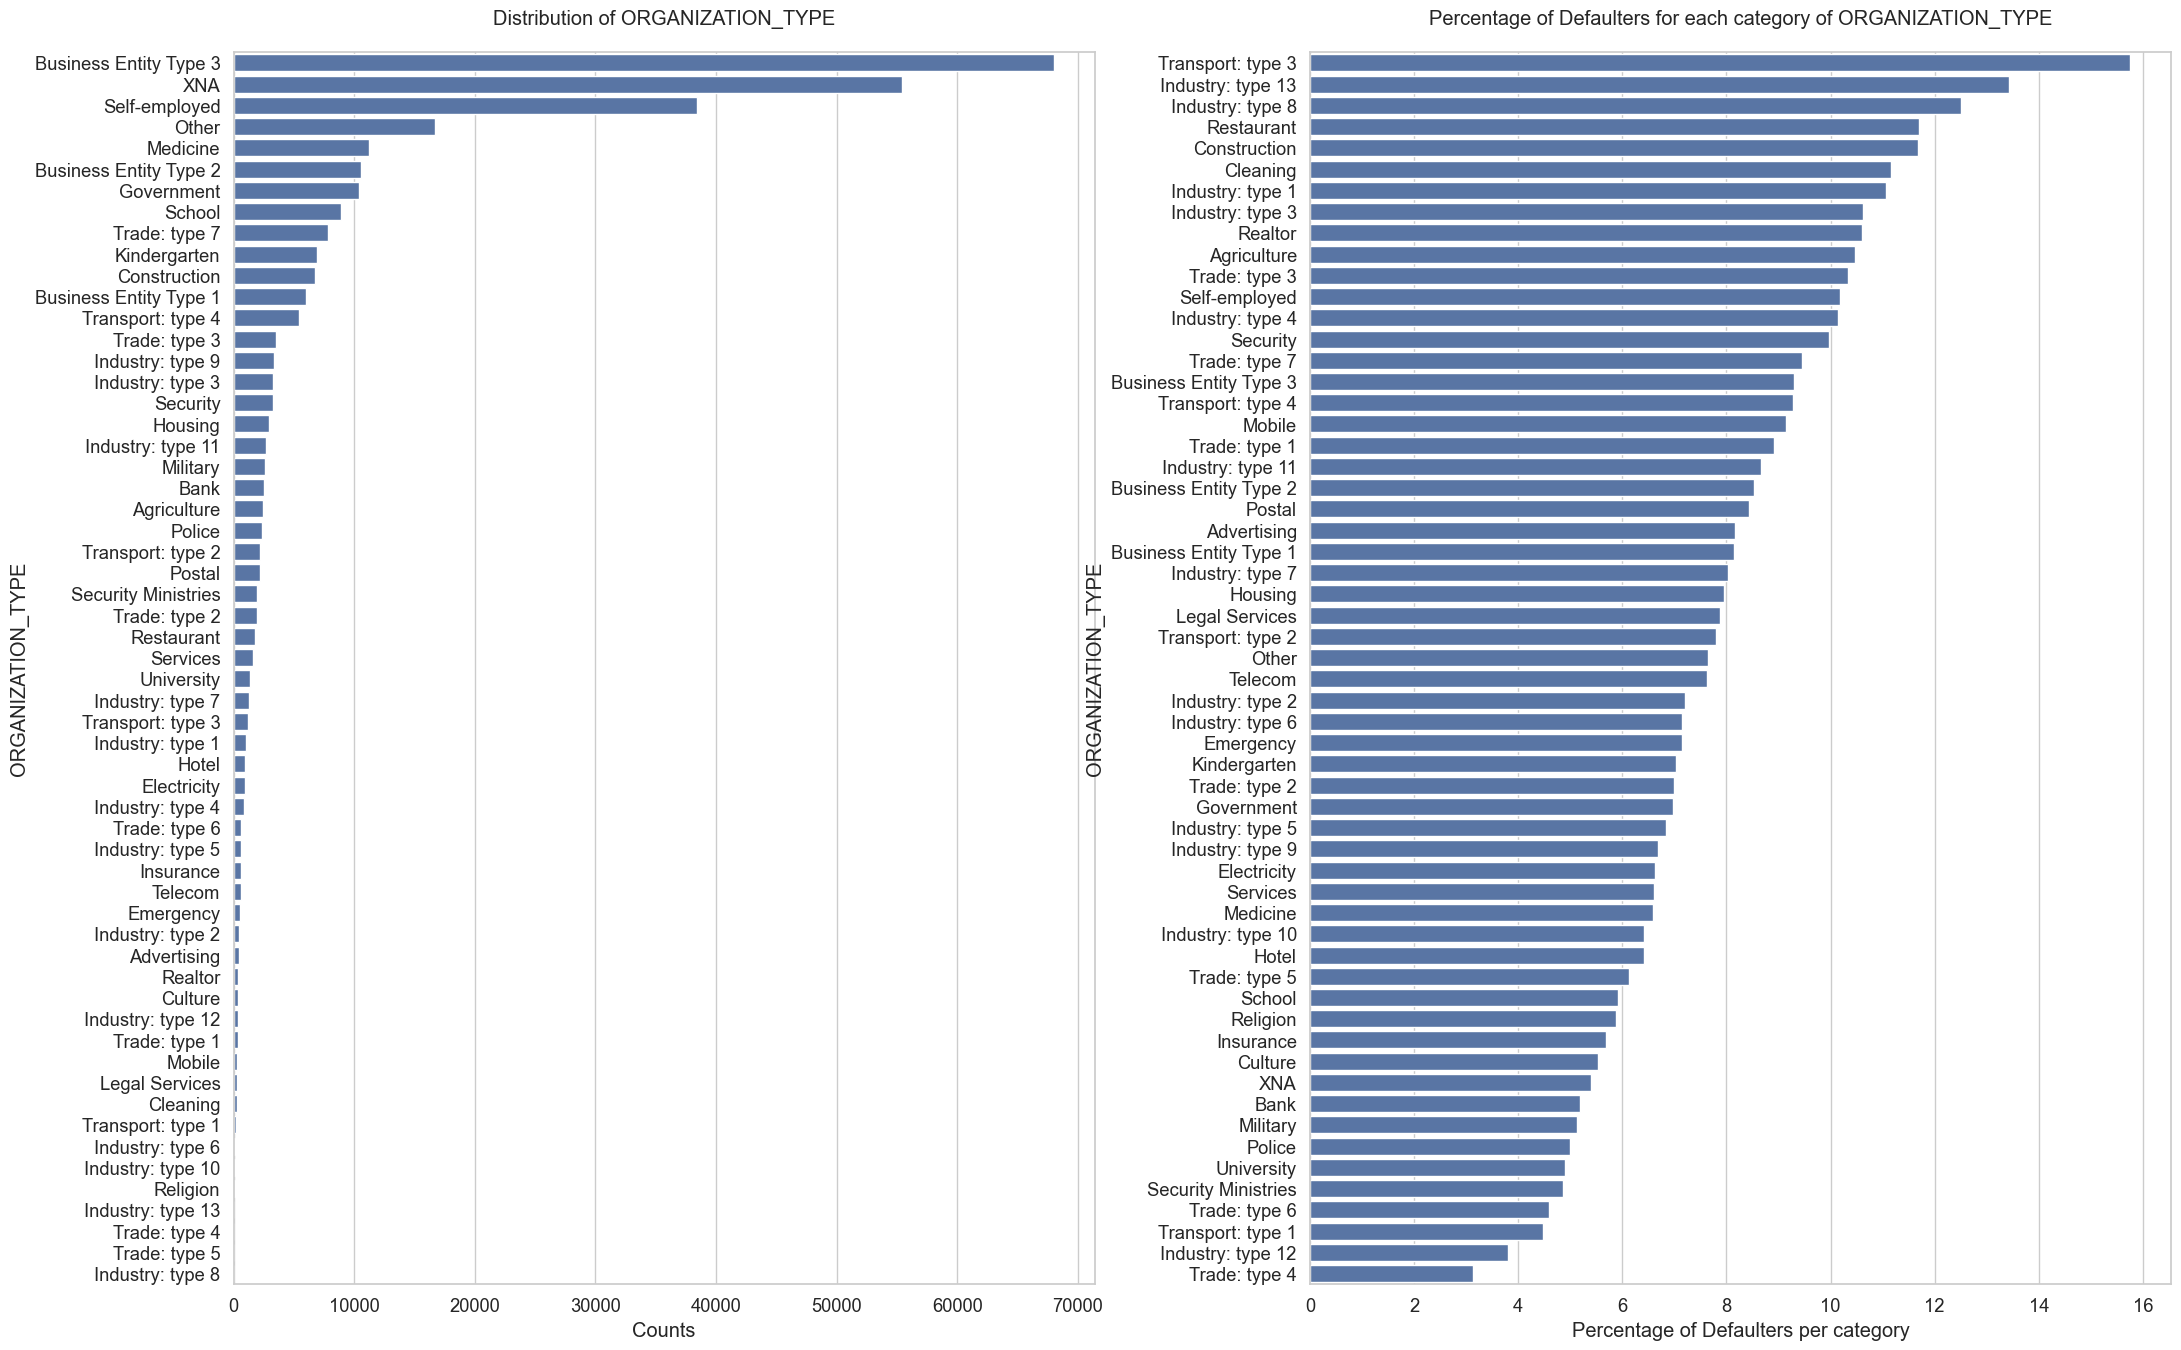

In [33]:
print(f"Total Number of categories of ORGANIZATION_TYPE = {len(train.ORGANIZATION_TYPE.unique())}")

plt.figure(figsize = (25, 16))
sns.set_style("whitegrid")
plt.subplots_adjust(wspace = 0.25)

plt.subplot(1, 2, 1)
count_organization = train.ORGANIZATION_TYPE.value_counts().sort_values(ascending = False)
sns.barplot(x = count_organization.values, y = count_organization.index)
plt.title('Distribution of ORGANIZATION_TYPE', pad = 20)
plt.xlabel('Counts')
plt.ylabel('ORGANIZATION_TYPE')

plt.subplot(1, 2, 2)
percentage_default_per_organization = train[train.TARGET == 1].ORGANIZATION_TYPE.value_counts()*100/count_organization
percentage_default_per_organization = percentage_default_per_organization.dropna().sort_values(ascending = False)
sns.barplot(x = percentage_default_per_organization.values, y = percentage_default_per_organization.index)
plt.title('Percentage of Defaulters for each category of ORGANIZATION_TYPE', pad = 20)
plt.xlabel('Percentage of Defaulters per category')
plt.ylabel('ORGANIZATION_TYPE')

plt.show()




### Выводы
1. Тип организации 'XNA'- неклассифицированный
2. Transport Type 3 - самый высокий уровень дефолтов
3. Trade type 4 - самый низкий уровень дефолтов

### REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY
REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY:
Совпадает ли постоянный адрес клиента с рабочим на региональном уровне

LIVE_CITY_NOT_WORK_CITY 
То же самое, только на уровне города

1 - не совпадает, 0 -  совпадает

Total Number of unique categories of REG_CITY_NOT_LIVE_CITY = 2


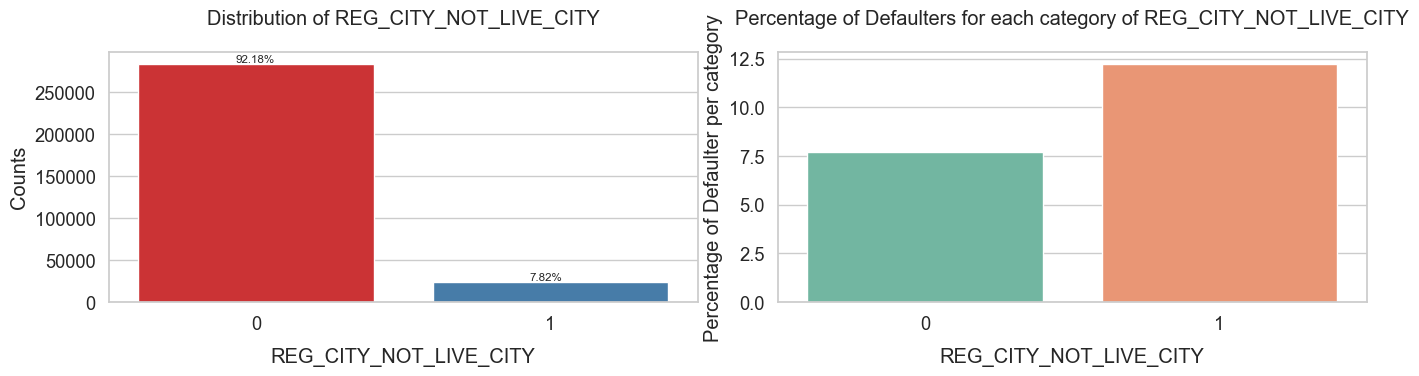

Total Number of unique categories of REG_CITY_NOT_WORK_CITY = 2


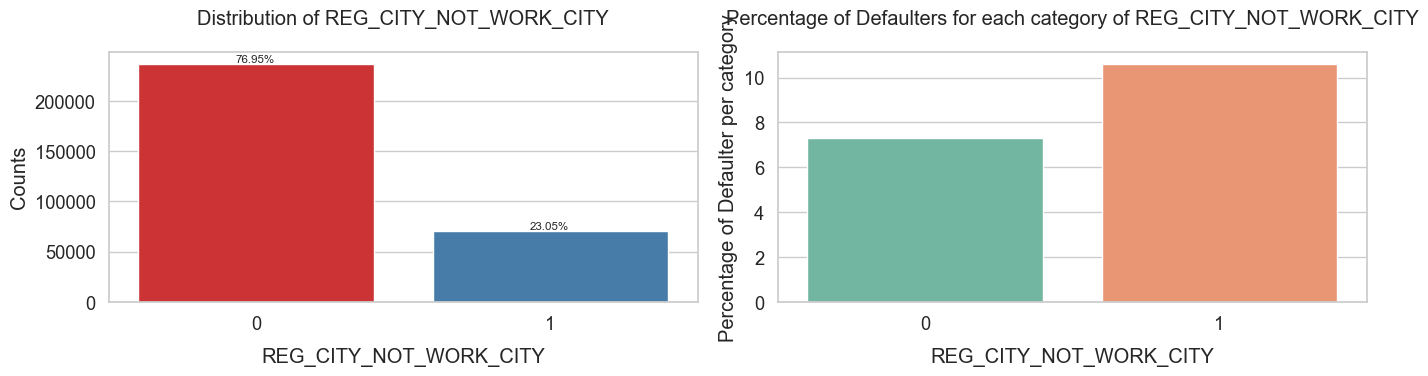

Total Number of unique categories of LIVE_CITY_NOT_WORK_CITY = 2


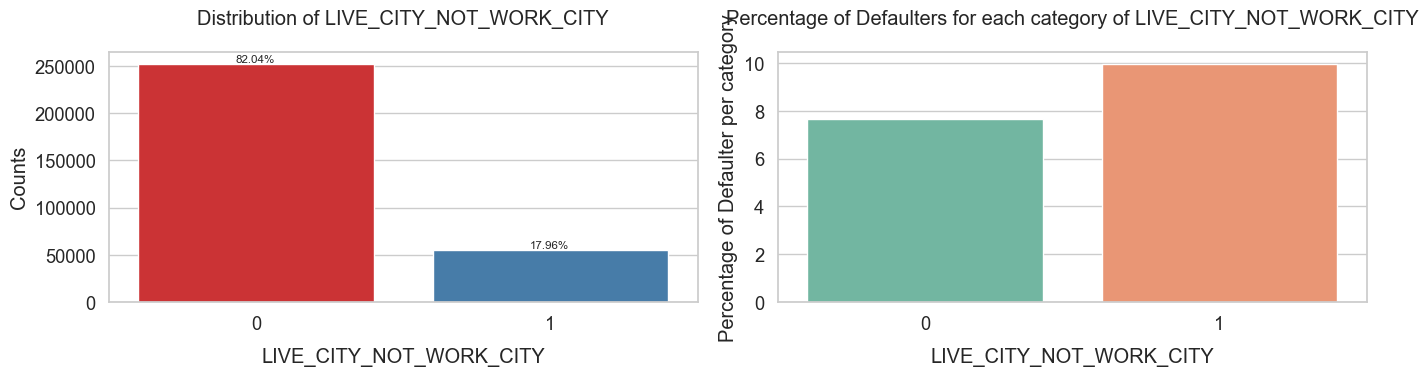

In [34]:

plot_categorical_variables_bar(train, column_name = 'REG_CITY_NOT_LIVE_CITY', figsize = (14, 4), horizontal_adjust = 0.33)
plot_categorical_variables_bar(train, column_name = 'REG_CITY_NOT_WORK_CITY', figsize = (14, 4), horizontal_adjust = 0.33)
plot_categorical_variables_bar(train, column_name = 'LIVE_CITY_NOT_WORK_CITY', figsize = (14, 4), horizontal_adjust = 0.33)

### Выводы
Для большинства адреса совпадают. Однако можно заметить тенденцию к дефолту для тех людей, у которыхх адреса отличаются

### FLAG_DOCUMENT_3
Предоставление документа (какого - неизвестно). 0 - был предоставлен, 1 - не был

Total Number of unique categories of FLAG_DOCUMENT_3 = 2


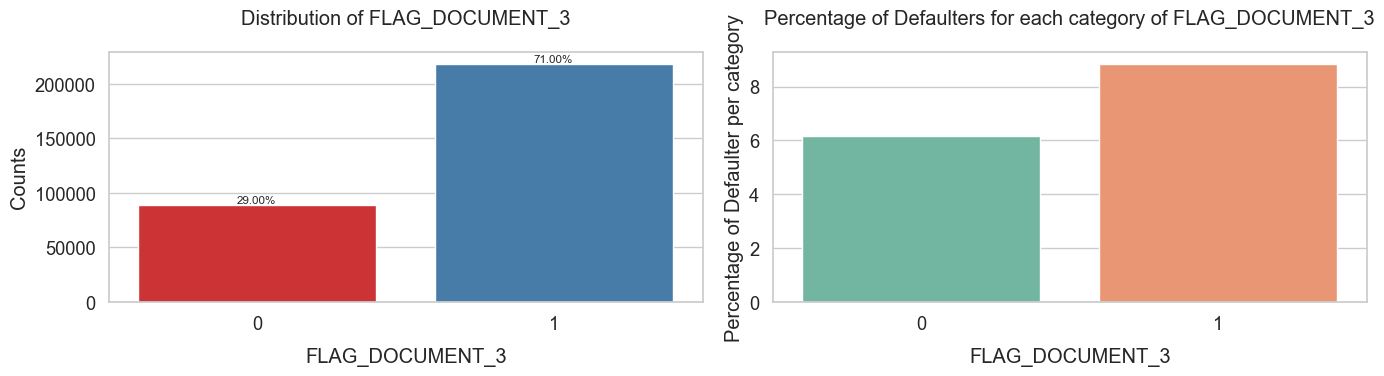

In [35]:
plot_categorical_variables_bar(train, column_name = 'FLAG_DOCUMENT_3', figsize = (14, 4), horizontal_adjust = 0.33)

### Выводы
1. большинство не предоставило документа
2. среди тех, кто не предоставил документ, вероятность дефолта выше

## Анализ непрерывных переменных

### AGE_YEARS
Возраст клиента

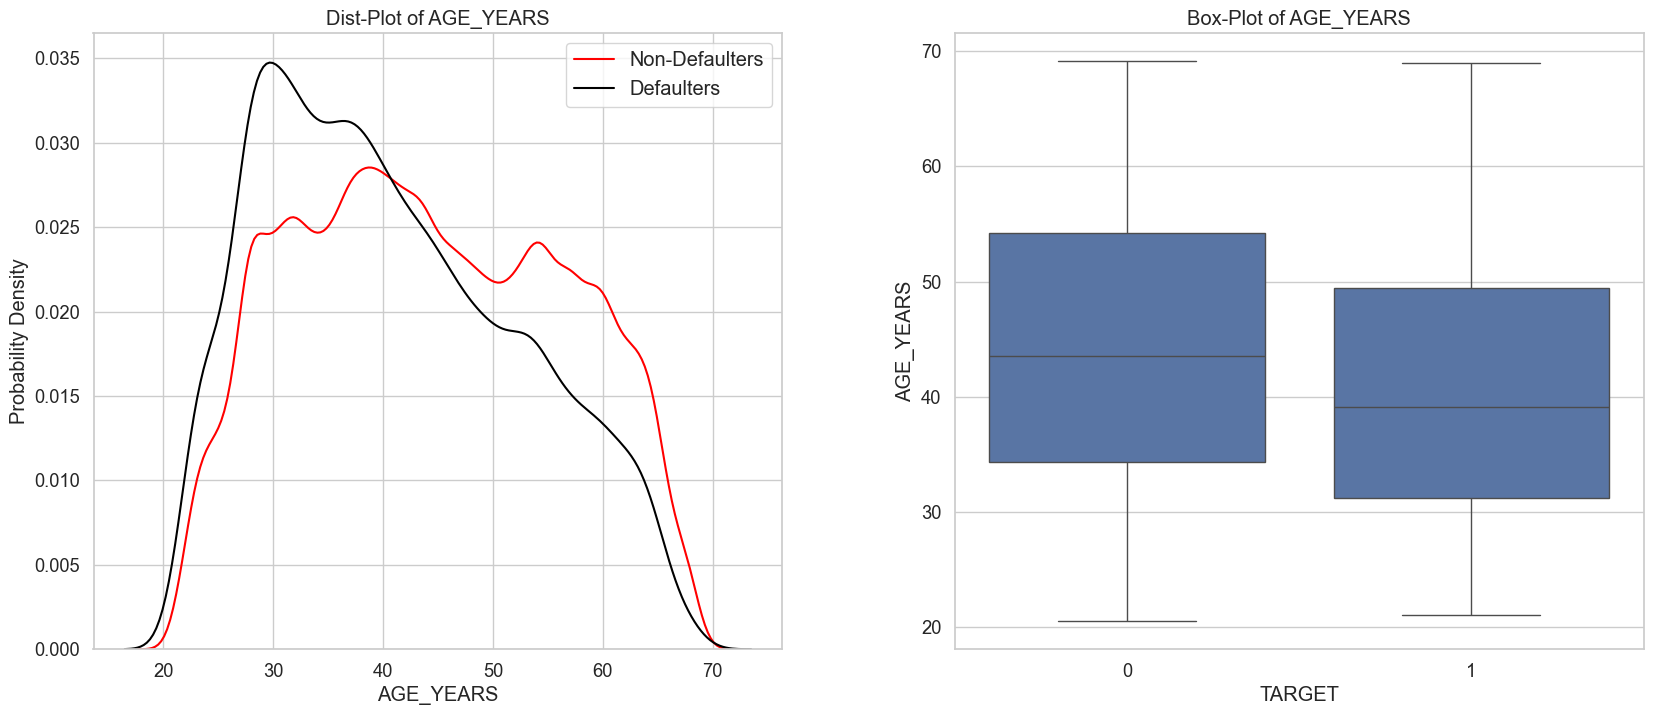

In [36]:
train['AGE_YEARS'] = train['DAYS_BIRTH'] * -1 / 365
plot_continuous_variables(train, 'AGE_YEARS', plots = ['distplot','box'])
_ = train.pop('AGE_YEARS')

### Выводы
1. Медианный возраст клиентов с дефолтом меньше.
2. То есть не возвращать кредиты склоны более молодые

### DAYS_EMPLOYED
Сколько дней клиент был устроен до того, как подал заявление (перевел в года)

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_EMPLOYED is -17912.0
The 25th percentile value of DAYS_EMPLOYED is -2760.0
The 50th percentile value of DAYS_EMPLOYED is -1213.0
The 75th percentile value of DAYS_EMPLOYED is -289.0
The 90th percentile value of DAYS_EMPLOYED is 365243.0
The 92th percentile value of DAYS_EMPLOYED is 365243.0
The 94th percentile value of DAYS_EMPLOYED is 365243.0
The 96th percentile value of DAYS_EMPLOYED is 365243.0
The 98th percentile value of DAYS_EMPLOYED is 365243.0
The 100th percentile value of DAYS_EMPLOYED is 365243.0
----------------------------------------------------------------------------------------------------


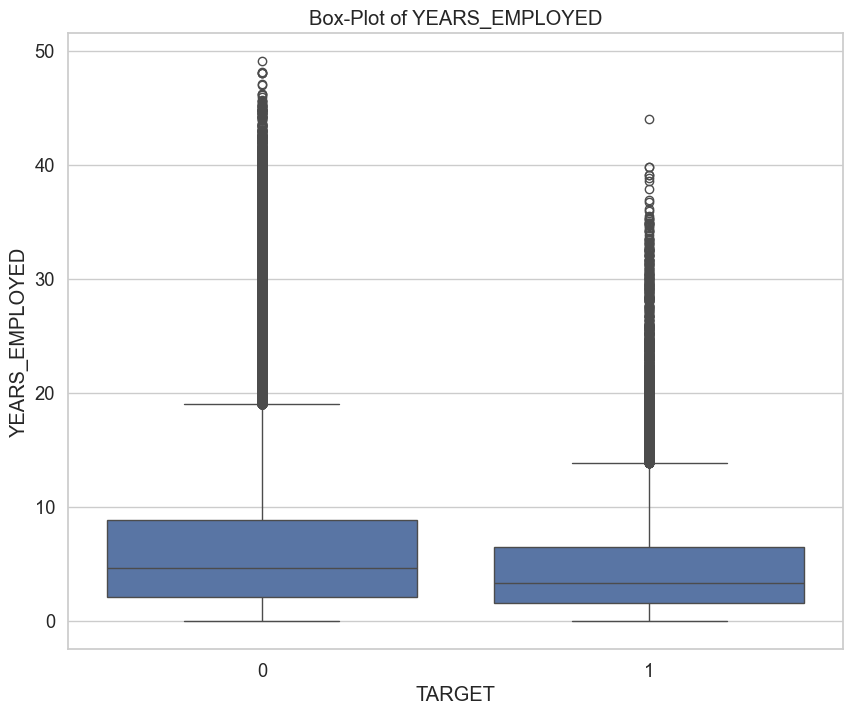

In [37]:
train['YEARS_EMPLOYED'] = train.DAYS_EMPLOYED * -1 / 365
print_percentiles(train, 'DAYS_EMPLOYED')
plot_continuous_variables(train, 'YEARS_EMPLOYED', plots = ['box'], scale_limits = [0,70], figsize = (10,8))
_ = train.pop('YEARS_EMPLOYED')

### EXT_SOURCES


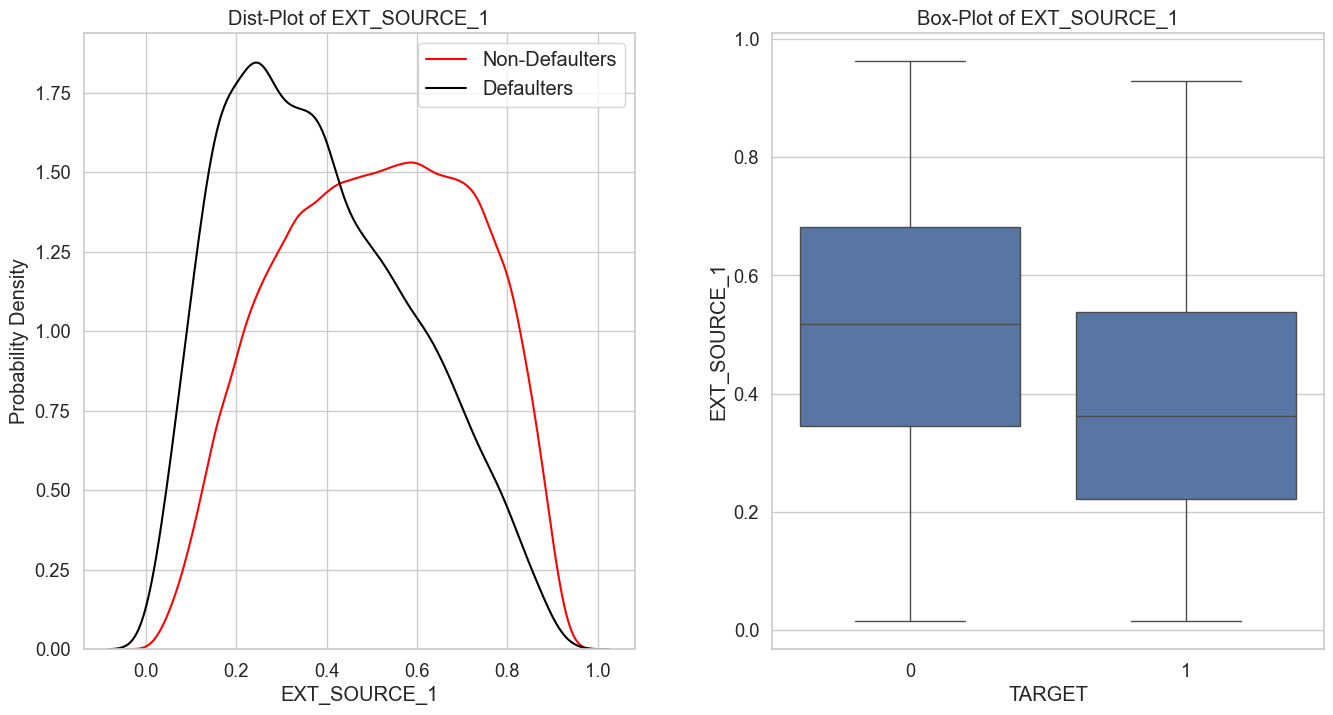

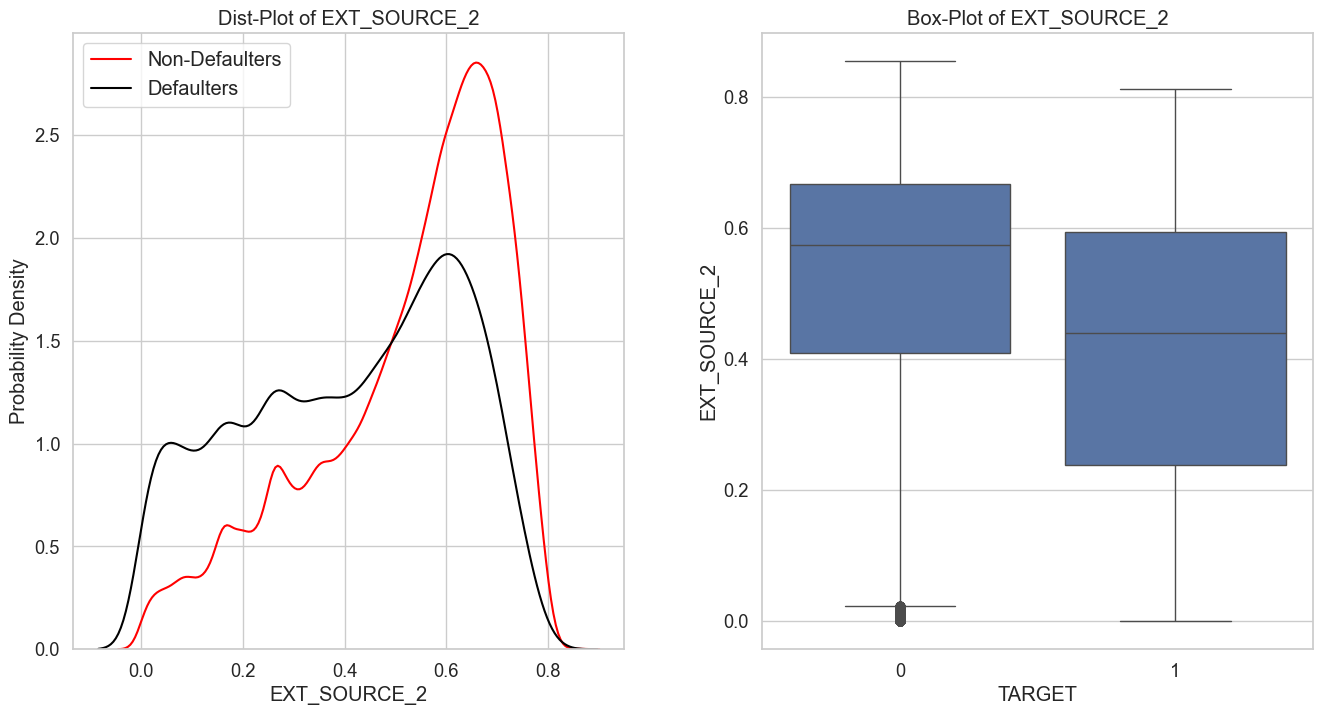

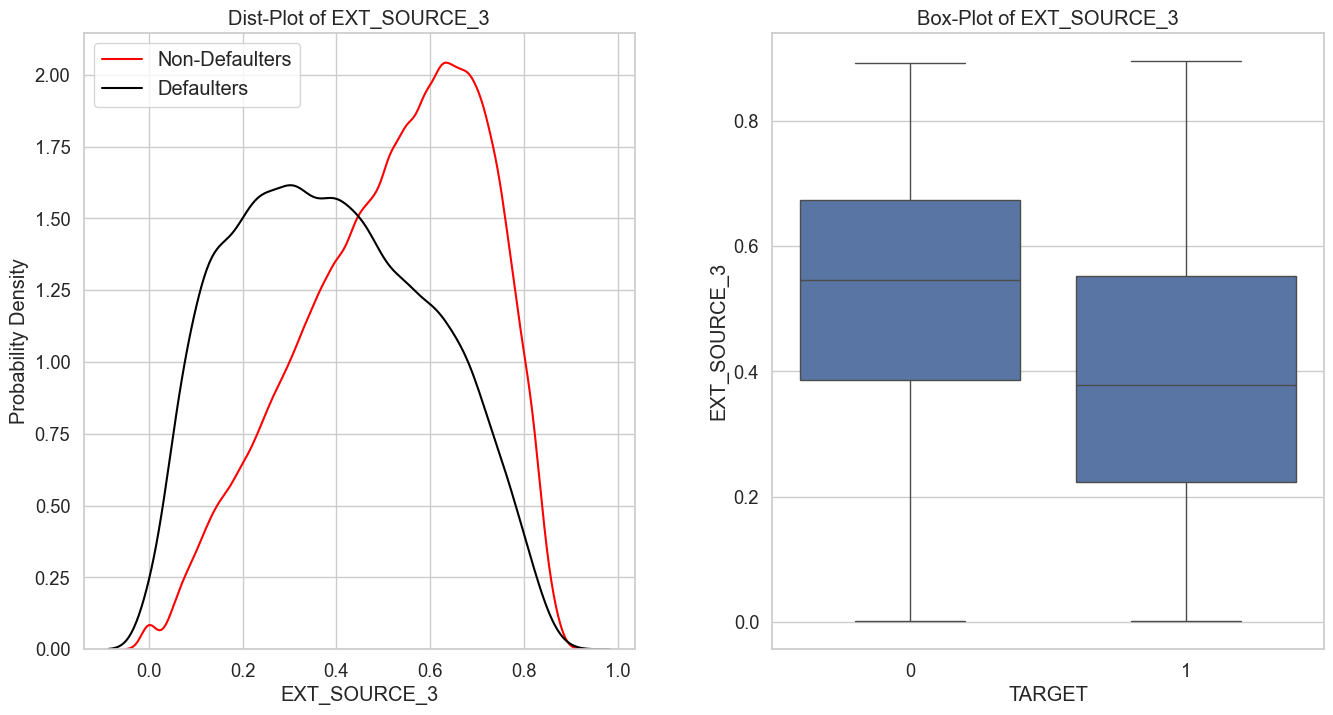

In [38]:

plot_continuous_variables(train, 'EXT_SOURCE_1', plots = ['distplot', 'box'], figsize = (16,8))

plot_continuous_variables(train, 'EXT_SOURCE_2', plots = ['distplot', 'box'], figsize = (16,8))

plot_continuous_variables(train, 'EXT_SOURCE_3', plots = ['distplot', 'box'], figsize = (16,8))

### Выводы
1. Наблюдается очень сильная корреляция этого признака с целеывой переменной. Те,кто получил дефолт, имекют стабильно более низкое значение параметра

## Результаты EDA
1. Для некоторых категорий видно влоне четкое различие между теми, у кого дефолт и у кого их нет
2. Некоторые признаки скоррелированы друг с другом и не несут никакой дополнительной информации, поэтому будут удалены.
3. Датасет несбаласированный по классам
4. Некоторые признаки содержат выбросы, которые нельзя удалить.